In [66]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from prophet import Prophet
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [67]:
# Load the .csv's into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')

### Stock Data Preprocessing

In [68]:
# Display the stock data
stock_data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.3333435058594,263.0433349609375,258.3333435058594,258.49334716796875,258.49334716796875,53868000,TSLA
1,2021-10-01,259.4666748046875,260.260009765625,254.52999877929688,258.40667724609375,258.40667724609375,51094200,TSLA
2,2021-10-04,265.5,268.989990234375,258.7066650390625,260.510009765625,260.510009765625,91449900,TSLA
3,2021-10-05,261.6000061035156,265.7699890136719,258.0666809082031,260.1966552734375,260.1966552734375,55297800,TSLA
4,2021-10-06,258.73333740234375,262.2200012207031,257.739990234375,260.9166564941406,260.9166564941406,43898400,TSLA


In [69]:
# Assess the data types of the DataFrame
stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12601 entries, 0 to 12600
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        12601 non-null  object
 1   Open        12601 non-null  object
 2   High        12601 non-null  object
 3   Low         12601 non-null  object
 4   Close       12601 non-null  object
 5   Adj Close   12601 non-null  object
 6   Volume      12601 non-null  object
 7   Stock Name  12601 non-null  object
dtypes: object(8)
memory usage: 787.7+ KB


In [70]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]

# Check for NaN and blank values in the DataFrame
blank_or_na_count = filtered_stock_data_df.map(lambda x: pd.isna(x) or x == '').sum()

# Display the count of NaN and blank values for each column
print(blank_or_na_count)

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Stock Name    0
dtype: int64


### Prepare Tweet Data

In [71]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [72]:
# Assess the data types of the DataFrame
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161587 entries, 0 to 161586
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Date          161587 non-null  object
 1   Tweet         161587 non-null  object
 2   Stock Name    161587 non-null  object
 3   Company Name  161587 non-null  object
dtypes: object(4)
memory usage: 4.9+ MB


In [73]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'], errors='coerce')
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
133229,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
133230,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
133231,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
133232,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


In [74]:
# Check for NaN and blank values in the DataFrame
tweet_blank_or_na_count = filtered_tweet_data_df.map(lambda x: pd.isna(x) or x == '').sum()

# Display the count of NaN and blank values for each column
print(tweet_blank_or_na_count)

Date          0
Stock Name    0
Tweet         0
dtype: int64


### Implement VADER Sentiment Analyzer on the Tweet data

In [75]:
# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['Neg', 'Neu', 'Pos', 'Compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))
filtered_tweet_data_df['Sentiment'] = filtered_tweet_data_df['Compound'].apply(vader_sentiment_label)

filtered_tweet_data_df

,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.125,0.763,0.113,0.0772,Positive
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.954,0.046,0.2960,Positive
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,Negative
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...,...
133229,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...,0.000,0.921,0.079,0.5040,Positive
133230,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...,0.071,0.905,0.024,-0.5106,Negative
133231,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...,0.089,0.821,0.091,-0.2263,Negative
133232,2021-09-30,AMZN,Great snapshot of what it looks like when an i...,0.000,0.745,0.255,0.9369,Positive


In [76]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'Compound' column
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['Compound'].mean().reset_index()
mean_score_df.rename(columns={'Compound': 'Mean Compound'}, inplace=True)

mean_score_df

,Date,Stock Name,Mean Compound
0,2021-09-30,AMZN,0.256980
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.256980
3,2021-09-30,PG,0.256980
4,2021-09-30,TSLA,0.251634
...,...,...,...
1763,2022-09-29,AMZN,0.086080
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.086080
1766,2022-09-29,PG,0.086080


In [77]:
# Merge the stock data and mean sentiment score DataFrames
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

merged_df = pd.merge(filtered_stock_data_df, mean_score_df, on=['Date', 'Stock Name'], how='inner').reset_index()

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis Label to the 'Mean Compound' column
merged_df['Sentiment'] = merged_df['Mean Compound'].apply(vader_sentiment_label)

merged_df = merged_df[['Date', 'Stock Name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mean Compound', 'Sentiment']]

merged_df

,Date,Stock Name,Open,High,Low,Close,Adj Close,Volume,Mean Compound,Sentiment
0,2021-09-30 00:00:00,TSLA,260.3333435058594,263.0433349609375,258.3333435058594,258.49334716796875,258.49334716796875,53868000,0.251634,Positive
1,2021-09-30 00:00:00,TSLA,260.3333435058594,263.0433349609375,258.3333435058594,258.49334716796875,258.49334716796875,53868000,0.251634,Positive
2,2021-10-01 00:00:00,TSLA,259.4666748046875,260.260009765625,254.52999877929688,258.40667724609375,258.40667724609375,51094200,0.222412,Positive
3,2021-10-01 00:00:00,TSLA,259.4666748046875,260.260009765625,254.52999877929688,258.40667724609375,258.40667724609375,51094200,0.222412,Positive
4,2021-10-04 00:00:00,TSLA,265.5,268.989990234375,258.7066650390625,260.510009765625,260.510009765625,91449900,0.151775,Positive
...,...,...,...,...,...,...,...,...,...,...
2449,2022-09-27 00:00:00,AMZN,117.19999694824219,118.31999969482422,113.05000305175781,114.41000366210938,114.41000366210938,60094700,-0.186740,Negative
2450,2022-09-28 00:00:00,AMZN,114.37999725341797,118.69999694824219,113.80000305175781,118.01000213623047,118.01000213623047,55763800,0.418660,Positive
2451,2022-09-28 00:00:00,AMZN,114.37999725341797,118.69999694824219,113.80000305175781,118.01000213623047,118.01000213623047,55763800,0.418660,Positive
2452,2022-09-29 00:00:00,AMZN,115.5999984741211,116.06999969482422,113.05999755859375,114.80000305175781,114.80000305175781,58969700,0.086080,Positive


In [78]:
#from sklearn.preprocessing import StandardScaler

# Inpmlement the StandardScaler
#scaler = StandardScaler()

# Select the columns to be scaled
#scaler.fit_transform(merged_df[['Mean Compound', 'Close']])
#merged_df.loc[:, 'Date'] = pd.to_datetime(merged_df['Date']).dt.date
# Fill NaN values in 'Mean Compound' with the mean of the column
#merged_df['Mean Compound'] = merged_df['Mean Compound'].fillna(merged_df['Mean Compound'].mean())

# Stadardized DataFrame
#print(merged_df.head())

### Create Initial Testing Loop

In [79]:
# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Loop through each stock name
for stock in stock_names_of_interest:
    # Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock]
    
    # Split data into training and test sets (80% train, 20% test)
    train_size = int(0.8 * len(stock_data))
    train_data = stock_data[:train_size]
    test_data = stock_data[train_size:]
    
    # Initialize the Prophet model
    model = Prophet()
    model.add_regressor('Mean Compound')
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'Mean Compound']])
    
    # Make future dataframe (for prediction up to the end of the test data)
    future = model.make_future_dataframe(periods=len(test_data), freq='D')
    future = future.merge(stock_data[['ds', 'Mean Compound']], on='ds', how='left')
    
    # Fill any NaN values in 'Mean Compound'
    future['Mean Compound'] = future['Mean Compound'].fillna(0)
    
    # Predict using the Prophet model
    forecast = model.predict(future)
    
    # Calculate performance metrics (compare actual y values from test set to predictions)
    y_true = test_data['y'].values  # Actual values
    y_pred = forecast['yhat'][-len(test_data):].values  # Predicted values
    
    # Compute performance metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Display performance report
    print(f"Performance Report for {stock}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")


19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing
19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for TSLA:
Mean Absolute Error (MAE): 125.3283
Mean Squared Error (MSE): 16492.5216
Root Mean Squared Error (RMSE): 128.4232
R-squared (R²): -88.0098


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for MSFT:
Mean Absolute Error (MAE): 19.2333
Mean Squared Error (MSE): 559.9976
Root Mean Squared Error (RMSE): 23.6643
R-squared (R²): -0.8323


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for PG:
Mean Absolute Error (MAE): 5.8337
Mean Squared Error (MSE): 47.4730
Root Mean Squared Error (RMSE): 6.8901
R-squared (R²): -0.8472


19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for META:
Mean Absolute Error (MAE): 9.8360
Mean Squared Error (MSE): 144.4937
Root Mean Squared Error (RMSE): 12.0206
R-squared (R²): -0.2811
Performance Report for AMZN:
Mean Absolute Error (MAE): 18.8218
Mean Squared Error (MSE): 431.3725
Root Mean Squared Error (RMSE): 20.7695
R-squared (R²): -4.3174


### Create Secondary Testing Loop

In [81]:
# Mapping the sentiment labels to numerical values
merged_df['Sentiment'] = merged_df['Sentiment'].map({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
})

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Sort the data by 'ds' (date) to ensure the rolling window works correctly
df = df.sort_values('ds')

# Calculate the 60-day rolling average based on the 'y' column (Close price)
df['60_day_moving_avg'] = df['y'].rolling(window=60).mean()
df['60_day_moving_avg'] = df['60_day_moving_avg'].fillna(0)

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Loop through each stock name
for stock in stock_names_of_interest:
    # Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock]
    
    # Split data into training and test sets (80% train, 20% test)
    train_size = int(0.8 * len(stock_data))
    train_data = stock_data[:train_size]
    test_data = stock_data[train_size:]
    
    # Initialize the Prophet model
    model = Prophet()
    model.add_regressor('Mean Compound')
    model.add_regressor('Volume')
    model.add_regressor('Sentiment')
    model.add_regressor('60_day_moving_avg')
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'Mean Compound', '60_day_moving_avg', 'Volume', 'Sentiment']])
    
    # Make future dataframe (for prediction up to the end of the test data)
    future = model.make_future_dataframe(periods=len(test_data), freq='D')
    future = future.merge(stock_data[['ds', 'Mean Compound', '60_day_moving_avg', 'Volume', 'Sentiment']], on='ds', how='left')
    
    # Fill any NaN values in 'Mean Compound'
    future['Mean Compound'] = future['Mean Compound'].fillna(0)
    future['Volume'] = future['Volume'].fillna(0)
    future['Sentiment'] = future['Sentiment'].fillna('0')
    future['60_day_moving_avg'] = future['60_day_moving_avg'].fillna('0')
    
    # Predict using the Prophet model
    forecast = model.predict(future)
    
    # Calculate performance metrics (compare actual y values from test set to predictions)
    y_true = test_data['y'].values  # Actual values
    y_pred = forecast['yhat'][-len(test_data):].values  # Predicted values
    
    # Compute performance metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Display performance report
    print(f"Performance Report for {stock}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")


19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing
19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for TSLA:
Mean Absolute Error (MAE): 159.2729
Mean Squared Error (MSE): 31533.2173
Root Mean Squared Error (RMSE): 177.5759
R-squared (R²): -169.1841


19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for MSFT:
Mean Absolute Error (MAE): 21.0696
Mean Squared Error (MSE): 661.7395
Root Mean Squared Error (RMSE): 25.7243
R-squared (R²): -1.1652


19:33:44 - cmdstanpy - INFO - Chain [1] start processing
19:33:44 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for PG:
Mean Absolute Error (MAE): 5.6758
Mean Squared Error (MSE): 45.7362
Root Mean Squared Error (RMSE): 6.7629
R-squared (R²): -0.7797


19:33:45 - cmdstanpy - INFO - Chain [1] start processing
19:33:45 - cmdstanpy - INFO - Chain [1] done processing


Performance Report for META:
Mean Absolute Error (MAE): 10.2077
Mean Squared Error (MSE): 152.8431
Root Mean Squared Error (RMSE): 12.3630
R-squared (R²): -0.3551
Performance Report for AMZN:
Mean Absolute Error (MAE): 24.3227
Mean Squared Error (MSE): 660.3621
Root Mean Squared Error (RMSE): 25.6975
R-squared (R²): -7.1400


### Create Prophet Model with Visualizations

19:50:24 - cmdstanpy - INFO - Chain [1] start processing
19:50:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


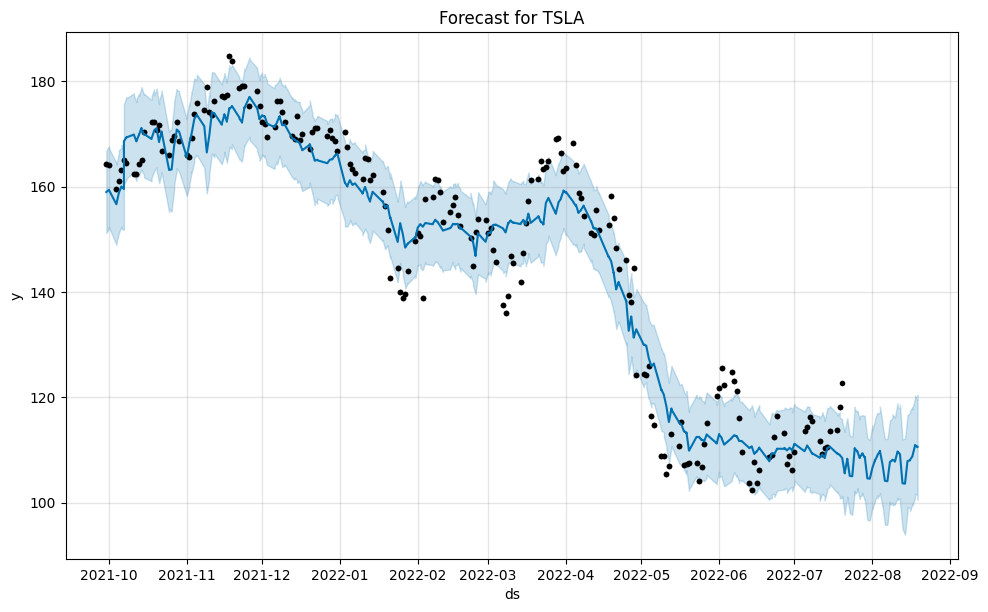

19:50:24 - cmdstanpy - INFO - Chain [1] start processing
19:50:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


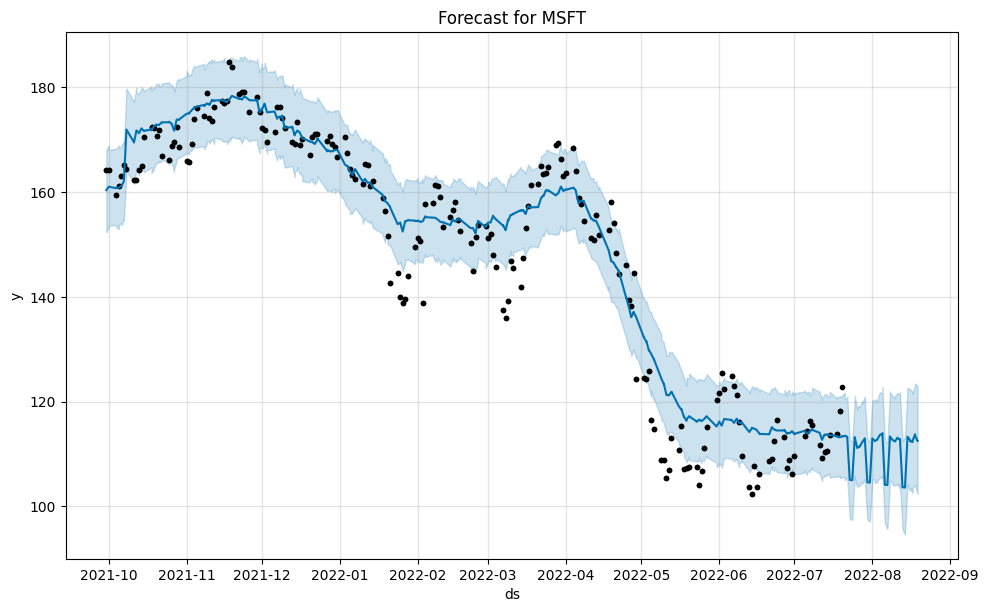

19:50:25 - cmdstanpy - INFO - Chain [1] start processing
19:50:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


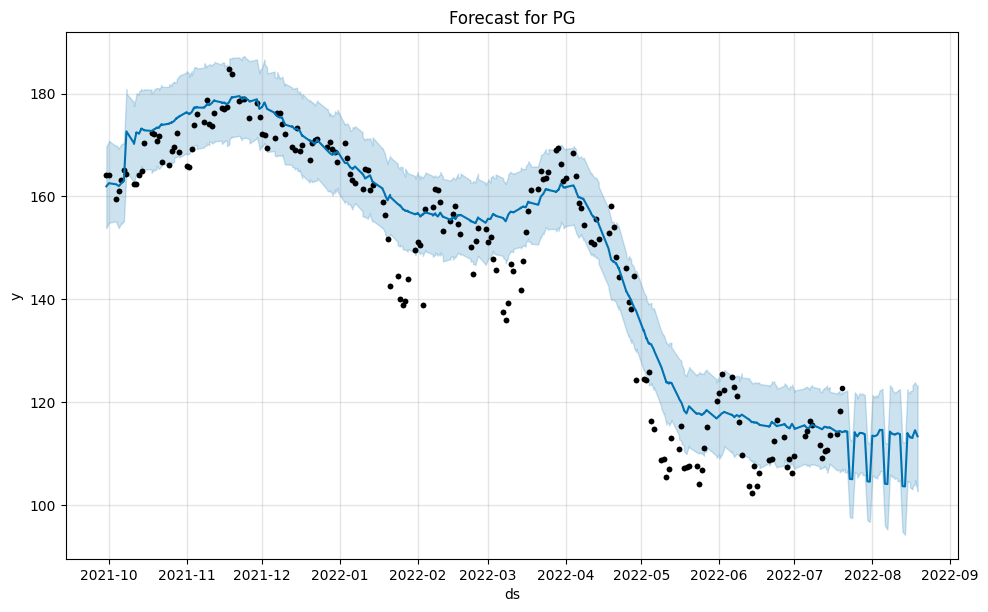

19:50:25 - cmdstanpy - INFO - Chain [1] start processing
19:50:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


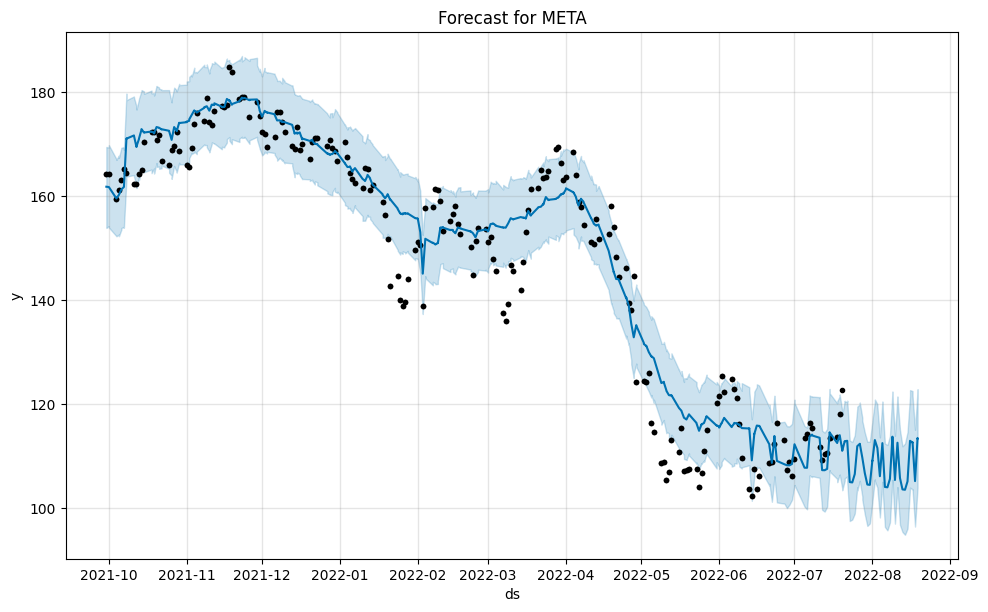

19:50:26 - cmdstanpy - INFO - Chain [1] start processing
19:50:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


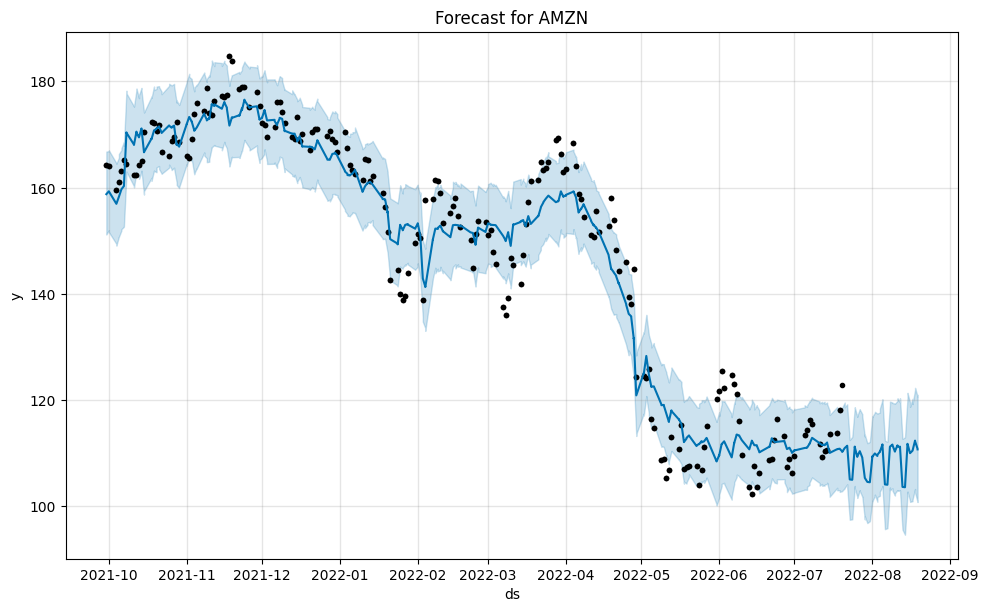

In [83]:
# Mapping the sentiment labels to numerical values
merged_df['Sentiment'] = merged_df['Sentiment'].map({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
})

# List of stock names to iterate over
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Rename 'Date' to 'ds' and 'Close' to 'y' to be compatible with Prophet
df = merged_df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Sort the data by 'ds' (date) to ensure the rolling window works correctly
df = df.sort_values('ds')

# Calculate the 60-day rolling average based on the 'y' column (Close price)
df['60_day_moving_avg'] = df['y'].rolling(window=60).mean()
df['60_day_moving_avg'] = df['60_day_moving_avg'].fillna(0)

# Convert 'ds' to datetime format if not already in that format
df['ds'] = pd.to_datetime(df['ds'])

# Loop through each stock name
for stock in stock_names_of_interest:
    # Filter the data for the current stock
    stock_data = df[df['Stock Name'] == stock]
    
    # Initialize the Prophet model
    model = Prophet()
    model.add_regressor('Mean Compound')
    model.add_regressor('Volume')
    model.add_regressor('Sentiment')
    model.add_regressor('60_day_moving_avg')
    
    # Train the model
    model.fit(train_data[['ds', 'y', 'Volume', 'Mean Compound', '60_day_moving_avg', 'Sentiment']])
    
    # Make future dataframe (predicting for 30 days in the future)
    future = model.make_future_dataframe(periods=30, freq='D')
    
    # Merge the future DataFrame with the regressors for predictions
    future = future.merge(stock_data[['ds', 'Volume', 'Mean Compound', '60_day_moving_avg', 'Sentiment']], on='ds', how='left')

    # After merging, fill any NaN values
    future['Mean Compound'] = future['Mean Compound'].fillna(0)
    future['Volume'] = future['Volume'].fillna(0)
    future['Sentiment'] = future['Sentiment'].fillna('0')
    future['60_day_moving_avg'] = future['60_day_moving_avg'].fillna('0')
    
    # Predict using the Prophet model
    forecast = model.predict(future)
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f"Forecast for {stock}")
    plt.show()
